In [1]:
import keras.metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import os
import pandas as pd
import tensorflow as tf
from keras import layers, models
image_dimension = (224, 224)

#### Load Data, Label for prediction (currently use one dataset (Brain MRI Data2))

In [4]:
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
locaion = "MRI_DATA"
image_set = list()
label_set = list()

for label in labels:
    path = os.path.join("Brain_MRI_data2", locaion, label)
    images = os.listdir(path)
    for image in tqdm(images):
        current_image = cv2.imread(os.path.join(path, image))
        current_image = cv2.resize(current_image, image_dimension)
        image_set.append(current_image)
        label_set.append(label)

features = np.array(image_set)
labels = pd.get_dummies(np.array(label_set)).values.argmax(1)

100%|██████████| 2658/2658 [00:02<00:00, 976.35it/s] 


In [3]:
features.shape

(10287, 224, 224, 3)

#### split dataset into train and test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.25, random_state=42)

#### Use a simple CNN for training

In [5]:
model_simple_cnn = models.Sequential()
model_simple_cnn.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model_simple_cnn.add(layers.Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model_simple_cnn.add(layers.MaxPooling2D())
model_simple_cnn.add(layers.Conv2D(32, 3, activation='relu'))
model_simple_cnn.add(layers.MaxPooling2D())
model_simple_cnn.add(layers.Conv2D(64, 3, activation='relu'))
model_simple_cnn.add(layers.MaxPooling2D())
model_simple_cnn.add(layers.Flatten())
model_simple_cnn.add(layers.Dense(128, activation='relu'))
model_simple_cnn.add(layers.Dense(4))
model_simple_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_simple_cnn.summary()

2023-02-09 16:44:24.803682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-09 16:44:24.803897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)    

In [6]:
epochs=50
history_simple_cnn = model_simple_cnn.fit(x=X_train,y=y_train,
                                          batch_size=8,epochs=epochs,
                                          validation_data=(X_val, y_val))

Epoch 1/50


2023-02-09 16:44:28.598680: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-09 16:44:28.965012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


965/965 [==============================] - ETA: 0s - loss: 0.5180 - accuracy: 0.8054

2023-02-09 16:44:49.949832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


965/965 [==============================] - 25s 24ms/step - loss: 0.5180 - accuracy: 0.8054 - val_loss: 0.2890 - val_accuracy: 0.8888
Epoch 2/50
965/965 [==============================] - 22s 23ms/step - loss: 0.1720 - accuracy: 0.9388 - val_loss: 0.2348 - val_accuracy: 0.9094
Epoch 3/50
200/965 [=====>........................] - ETA: 15s - loss: 0.0777 - accuracy: 0.9712

KeyboardInterrupt: 

<AxesSubplot:xlabel='epoch'>

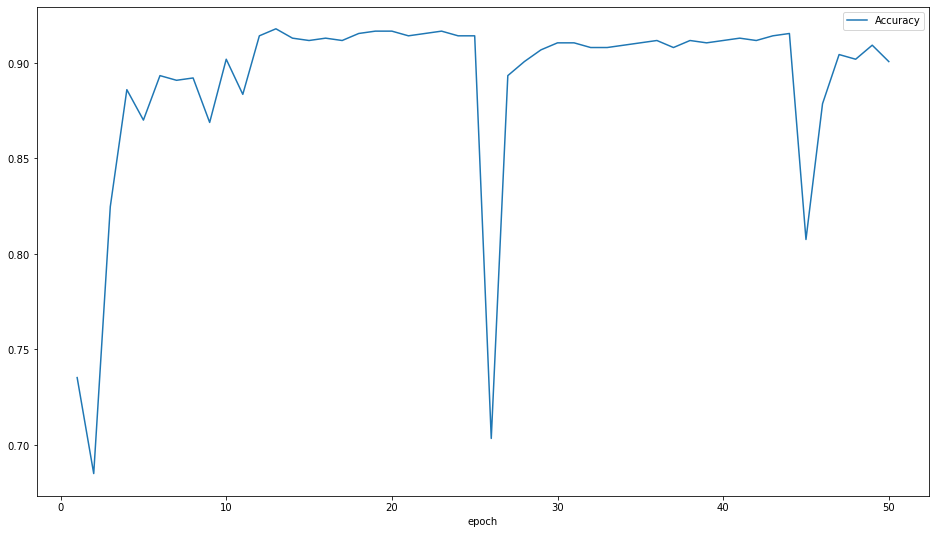

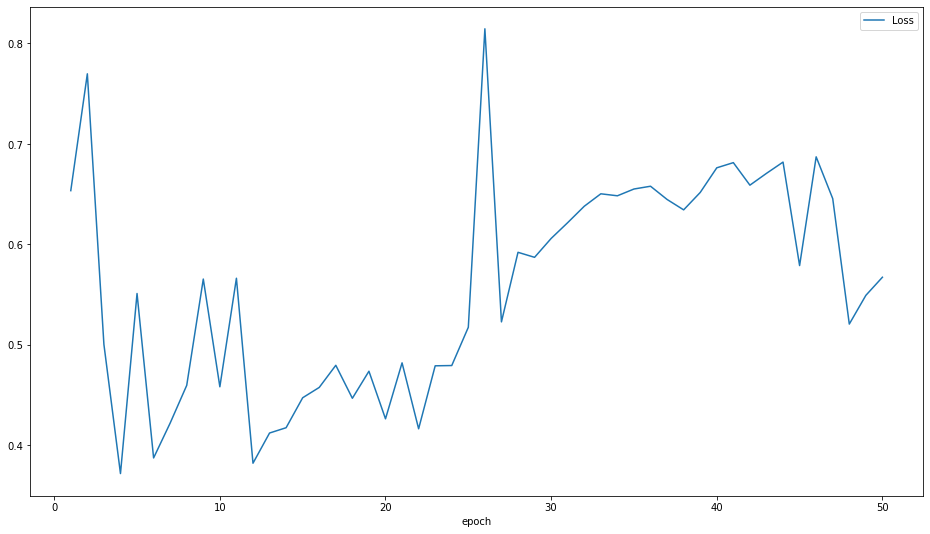

In [85]:
epoch_index = [i for i in range(1, 51)]
simple_cnn_result = pd.DataFrame({"epoch": epoch_index,
                                  "Accuracy": history_simple_cnn.history["val_accuracy"],
                                  "Loss": history_simple_cnn.history["val_loss"]})
simple_cnn_result.plot.line(x='epoch', y=['Accuracy'], figsize=(16, 9))
simple_cnn_result.plot.line(x='epoch', y=['Loss'], figsize=(16, 9))

#### Using Resnet50 for training

In [7]:
model_resnet = tf.keras.applications.resnet.ResNet50()
model_resnet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model_resnet.fit(x=X_train,
                    y=y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val))

Epoch 1/50


2023-02-09 16:45:32.525171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.8697

2023-02-09 16:47:32.169327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 134s 512ms/step - loss: 0.4464 - accuracy: 0.8697 - val_loss: 14.1995 - val_accuracy: 0.2687
Epoch 2/50
 71/242 [=======>......................] - ETA: 1:16 - loss: 0.1803 - accuracy: 0.9349

KeyboardInterrupt: 

<AxesSubplot:xlabel='epoch'>

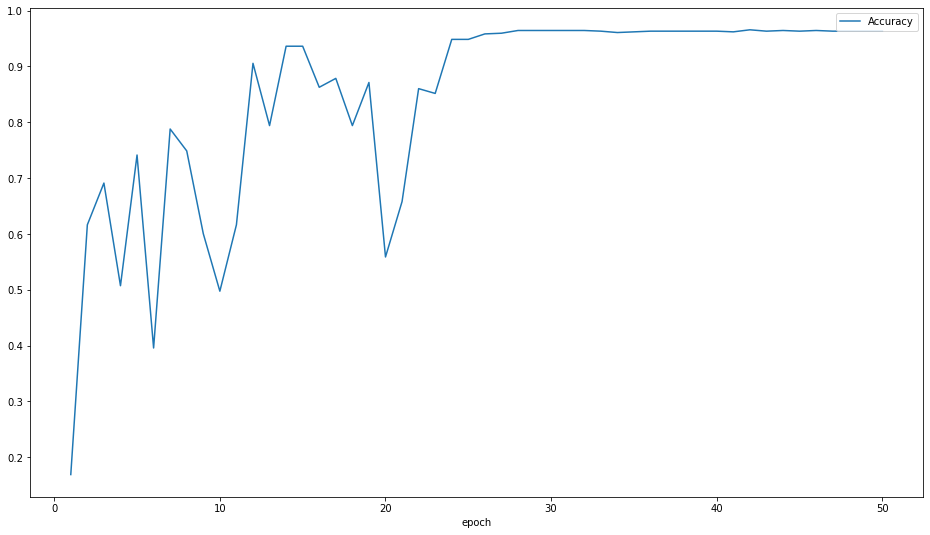

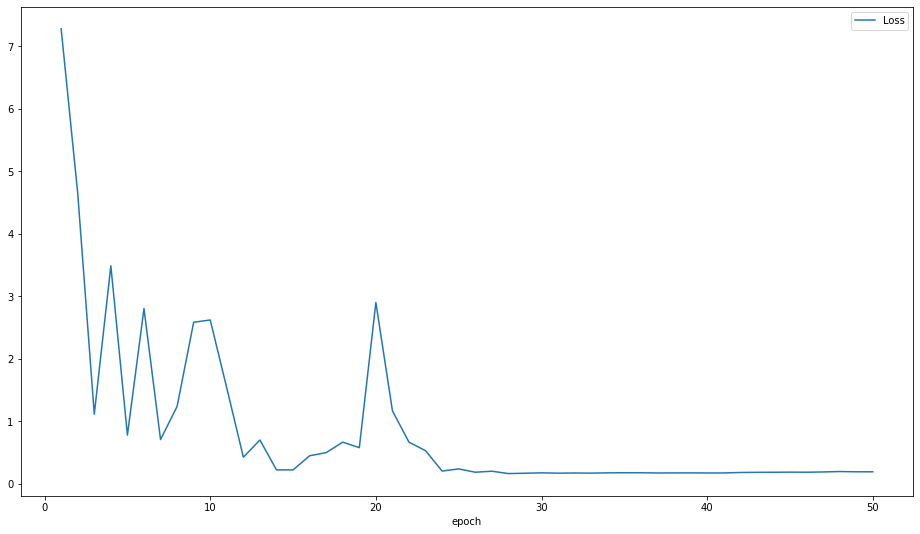

In [92]:
epoch_index = [i for i in range(1, 51)]
resnet_result = pd.DataFrame({"epoch": epoch_index,
                                  "Accuracy": model_resnet.history.history["val_accuracy"],
                                  "Loss": model_resnet.history.history["val_loss"]})
resnet_result.plot.line(x='epoch', y=['Accuracy'], figsize=(16, 9))
resnet_result.plot.line(x='epoch', y=['Loss'], figsize=(16, 9))

#### Using Efficient-B0

In [3]:
model_efficientB0 = tf.keras.applications.efficientnet.EfficientNetB0()
model_efficientB0.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro


2023-02-09 17:29:14.894705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-09 17:29:14.895071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


21834768/21834768 [==============================] - 3s 0us/step


In [8]:
model_efficientB0.fit(x=X_train,
                    y=y_train,
                    epochs=1,
                    validation_data=(X_val, y_val))

2023-02-09 17:30:08.297298: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-09 17:30:12.016170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.9078

2023-02-09 17:31:48.017120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 109s 392ms/step - loss: 0.3597 - accuracy: 0.9078 - val_loss: 0.7504 - val_accuracy: 0.8118
